In [1]:
from pathlib import Path
import re
from datetime import datetime, timezone

import numpy as np
import xarray as xr
import rioxarray

from pyproj import CRS, Transformer
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from ros_database.ims_snow.ims_crs import (IMS24NorthPolarStereo, 
                                           WGS84toIMS24NorthPolarStereo,
                                           WGS84,
                                           IMS24Grid)
from ros_database.ims_snow.get_snow_cover import read_ims_ascii

/home/apbarret/mambaforge/envs/rain_on_snow_database/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
filepath = Path("/home/apbarret/Downloads/ims1997036_00UTC_24km_v1.1.asc.gz")

## Read the data from the gzipped ascii file

I know from the CRS of the dataset that the Americas are at the bottom of the image and Eurasia at the top.  So the image origin (col=0, row=0) is in the lower left corner of the image.  By default `imshow` assumes images follow convention and have the origin at the upper-left corner of the upper-left pixel.  Setting `origin="lower"` plots the data in the correct orientation. 

In [3]:
data = read_ims_ascii(filepath)
data
# print(data.shape)
# plt.imshow(data, origin="lower")

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

The image is coded as follows:
0: No data - not on the Earth
1: Water
2: Land
3: Sea ice
4: Snow covered land

We'll set the "No data" pixels to NaN.

In [4]:
data = np.where(data > 0, data, np.nan)

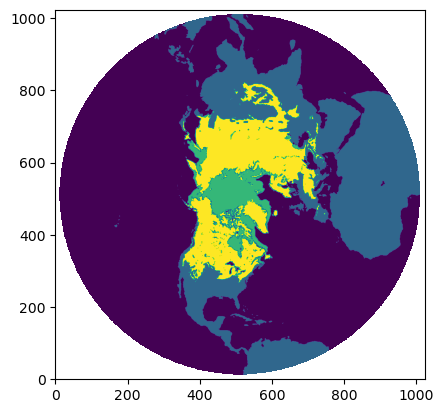

In [5]:
plt.imshow(data, origin="lower")

## Create a `xarray.Dataset`

The data is an array of values.  By creating an `xarray.Dataset` from the data we can make the data much richer and more useable.

`xarray.Datasets` are _data structures_ for N-dimensional datasets that are designed around the concept of the CF-Compliant NetCDF file format.  This file format, when formatted correctly in accordance with CF guidelines, contains not only data but also the coordinate system for data, allowing it to be used as a georeferenced dataset; attributes for each data variable in the dataset, such as units and a standard name, which allows user to understand and apply the data _straight-out-of-the-box_; and other information about the dataset creator, data source, etc.

`xarray.Datasets` and the `xarray` package also come with a set of methods that make working with this kind of data relatively easy.  The `rioxarray` extension to `xarray` adds geospatial methods such as coordinate transformations and clipping.

### Create `xarray.Dataset`

We'll create an `xarray.Dataset` using the `Dataset` method.  We need to provide a name for the data variable.  Here I use `surface_cover`.  We also need to give the dimensions of the data names.  The data is in a projected coordinate system (more on that below) so the dimensions can be named `x` and `y` following the conventional for a cartesian coordinate system.

This information is provided as a dictionary with the data variable name as the dictionary key.  The dictionary value is a `tuple` containing a `list` of the dimension name and the numpy array containing the data values.  Numpy arrays are _row major_, meaning that the first dimension is the number of rows and the second dimension the number of columns.  Row number corresponds to the `y` axis and column number to the `x` axis, so the `list` of dimension names has `y` first.

In [6]:
ds = xr.Dataset({"surface_cover": (['y', 'x'], data)})
ds

<xarray.Dataset> Size: 8MB
Dimensions:        (y: 1024, x: 1024)
Dimensions without coordinates: y, x
Data variables:
    surface_cover  (y, x) float64 8MB nan nan nan nan nan ... nan nan nan nan

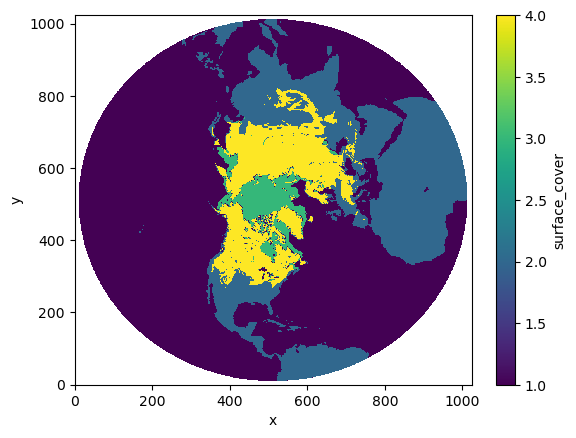

In [7]:
ds.surface_cover.plot()

### Create coordinates

At the moment, the `Dataset`, `ds`, has named dimensions but there are no coordinates associated with these dimensions.  In the plot above, the `x` and `y` axes have column and row indices as tickvalues.  These are _image coordinates_.  Indexing the dataset with `x=450` and `y=400`, will return the `surface_cover` for the pixel in 450th column and 400th row.  There is no information in the Dataset to relate these image coordinates to a location on the surface of the Earth.

To relate image coordinates to a location on Earth, we need to add two pieces of information: _projected coordinates_ and a _coordinate reference system_ (CRS).  The projected coordinates give the `x` and `y` location of a pixel on a cartesian plane.  The CRS relates this flat, cartesian plane to a location on the surface of ellipsoidal Earth.  We'll add projected coordinates first.

I have created a `Grid` class to make working with gridded data easier.  

```
from ros_database.ims_snow.ims_crs import Grid

help(Grid)
class Grid(builtins.object)
 |  Grid(nrow, ncol, grid_cell_width, grid_cell_height, grid_origin_x, grid_origin_y, grid_rotation_x=0.0, grid_rotation_y=0.0, crs=None)
 |
 |  Class for grid operations
```

`IMS24Grid` is an instance of this `Grid` class that has been initialised with the grid parameters for the IMS 24 km grid.  The grid instance also has CRS information as a `pyproj.CRS` instance.

You can see the grid parameters by printing `IMS24Grid`

In [8]:
print(IMS24Grid)

Grid object
    nrow: 1024
    ncol: 1024
    grid_cell_width: 23684.997
    grid_cell_height: 23684.997
    grid_origin_x: -12126718.464
    grid_origin_y: -12126718.464



`x` and `y` projected coordinates are returned by calling `xy_coords`

In [9]:
x, y = IMS24Grid.xy_coords()
print(x)
print(y)

[-12114875.9655 -12091190.9685 -12067505.9715 ...  12067505.9715
  12091190.9685  12114875.9655]
[-12114875.9655 -12091190.9685 -12067505.9715 ...  12067505.9715
  12091190.9685  12114875.9655]


Coordinate variables in CF-Compliant NetCDF files should have attributes describing the name of the axis and units for each coordinate.  We can use the `to_cf` method of `pyproj.CRS.coordinare_system` to get the correct attribute names and values.  This returns a list of dictionaries, one dictionary for each spatial coordinate.  If a CRS has been assigned to IMS24Grid we can access this directly through `IMS24Grid.crs`.

I create `xarray.DataArray` objects for x and y coordinates and assign the coordinate system attributes to these `DataArrays`.

In [10]:
x = xr.DataArray(x, coords={'x': x}, attrs=IMS24Grid.crs.coordinate_system.to_cf()[0])
y = xr.DataArray(y, coords={'y': y}, attrs=IMS24Grid.crs.coordinate_system.to_cf()[1])
x, y

(<xarray.DataArray (x: 1024)> Size: 8kB
 array([-12114875.9655, -12091190.9685, -12067505.9715, ...,
         12067505.9715,  12091190.9685,  12114875.9655])
 Coordinates:
   * x        (x) float64 8kB -1.211e+07 -1.209e+07 ... 1.209e+07 1.211e+07
 Attributes:
     axis:           X
     long_name:      Easting
     standard_name:  projection_x_coordinate
     units:          metre,
 <xarray.DataArray (y: 1024)> Size: 8kB
 array([-12114875.9655, -12091190.9685, -12067505.9715, ...,
         12067505.9715,  12091190.9685,  12114875.9655])
 Coordinates:
   * y        (y) float64 8kB -1.211e+07 -1.209e+07 ... 1.209e+07 1.211e+07
 Attributes:
     axis:           Y
     long_name:      Northing
     standard_name:  projection_y_coordinate
     units:          metre)

The coordinate `DataArrays` are then assigned to the `Dataset` using `assign_coords`.

I could also have assigned to numpy arrays directly and then assigned the attributes using
```
ds.x.attrs = IMS24Grid.crs.coordinate_system.to_cf()[0]
```

In [11]:
ds = ds.assign_coords(x=x, y=y)
ds

<xarray.Dataset> Size: 8MB
Dimensions:        (y: 1024, x: 1024)
Coordinates:
  * x              (x) float64 8kB -1.211e+07 -1.209e+07 ... 1.209e+07 1.211e+07
  * y              (y) float64 8kB -1.211e+07 -1.209e+07 ... 1.209e+07 1.211e+07
Data variables:
    surface_cover  (y, x) float64 8MB nan nan nan nan nan ... nan nan nan nan

A Plot of the data now has the projected coordinates as axes.

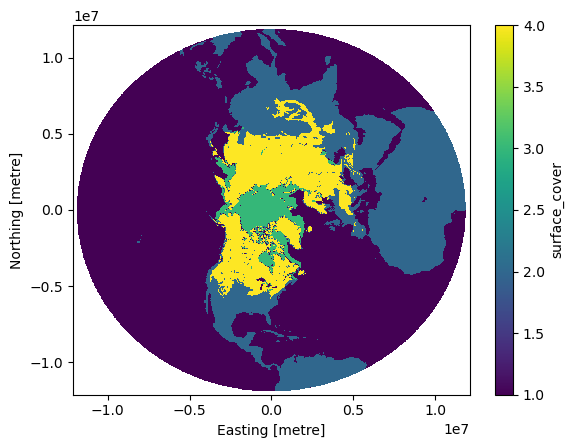

In [12]:
ds.surface_cover.plot.imshow()

### Add Coordinate Reference System

Assigning the CRS to the dataset properly documents how the coordinates are related to the Earth.  Just as we used the `to_cf` method for the coordinate system, we can use the `to_cf` method for the CRS to assign CF-Compliant attributes describing the CRS to the Dataset.  This is done by using an accessor method provided by `rioxarray`.  `rioxarray` was imported at the beginning and `xarray` is "aware" of the `rioxarray` methods.

In [13]:
IMS24Grid.crs.to_cf()

{'crs_wkt': 'PROJCRS["unknown",BASEGEOGCRS["unknown",DATUM["unknown",ELLIPSOID["unknown",6371200,0,LENGTHUNIT["metre",1,ID["EPSG",9001]]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8901]]],CONVERSION["unknown",METHOD["Polar Stereographic (variant B)",ID["EPSG",9829]],PARAMETER["Latitude of standard parallel",60,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8832]],PARAMETER["Longitude of origin",-80,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8833]],PARAMETER["False easting",-121.487472489721,LENGTHUNIT["metre",1],ID["EPSG",8806]],PARAMETER["False northing",-121.487472489721,LENGTHUNIT["metre",1],ID["EPSG",8807]]],CS[Cartesian,2],AXIS["(E)",south,MERIDIAN[90,ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]],ORDER[1],LENGTHUNIT["metre",1,ID["EPSG",9001]]],AXIS["(N)",south,MERIDIAN[180,ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]],ORDER[2],LENGTHUNIT["metre",1,ID["EPSG",9001]]]]',
 'semi_major_axis': 6371200.0,
 'semi_minor_axis': 637120

In [14]:
grid_mapping_name = "ims_polar_stereographic"
ds.rio.write_crs(IMS24Grid.crs, grid_mapping_name=grid_mapping_name, inplace=True)
ds

<xarray.Dataset> Size: 8MB
Dimensions:                  (y: 1024, x: 1024)
Coordinates:
  * x                        (x) float64 8kB -1.211e+07 -1.209e+07 ... 1.211e+07
  * y                        (y) float64 8kB -1.211e+07 -1.209e+07 ... 1.211e+07
    ims_polar_stereographic  int64 8B 0
Data variables:
    surface_cover            (y, x) float64 8MB nan nan nan nan ... nan nan nan

In [15]:
ds.surface_cover.encoding

{'grid_mapping': 'ims_polar_stereographic'}

### Add time coordinate

Even if a dataset is for a single time step, it is helpful to assign a time coordinate.  This allows datasets to be concatenated along the time dimensions without user having to write extra code to add timestamps.

For this data set, the timestamp is in the filename, and consists of a year and day of year and hour in UTC.

In [16]:
def timestamp_from_filepath(filepath: Path) -> datetime:
    """Parses filepath to get timestamp"""
    m = re.search(r"ims(\d{7}_\d{2})UTC", filepath.name)
    if m:
        time = datetime.strptime(m.groups()[0], "%Y%j_%H")  #.replace(tzinfo=timezone.utc)
    else:
        raise ValueError("Unable to find timestamp-like string in {filepath.name}")
    return time

#ds = ds.expand_dims("time", axis=0)
ds = ds.expand_dims(dim={"time": 1}, axis=0)
ds["time"] = [timestamp_from_filepath(filepath)]  #xr.DataArray(timestamp_from_filepath(filepath), dims=["time"], attrs={"long_name": "time"})
ds.time.attrs = {
    "long_name": "time",
}

ds.time.encoding = {
    "units": "days since 1979-1-1 00:00:00UTC",
    "calendar": "standard",
}

ds

<xarray.Dataset> Size: 8MB
Dimensions:                  (time: 1, y: 1024, x: 1024)
Coordinates:
  * x                        (x) float64 8kB -1.211e+07 -1.209e+07 ... 1.211e+07
  * y                        (y) float64 8kB -1.211e+07 -1.209e+07 ... 1.211e+07
    ims_polar_stereographic  int64 8B 0
  * time                     (time) datetime64[ns] 8B 1997-02-05
Data variables:
    surface_cover            (time, y, x) float64 8MB nan nan nan ... nan nan

### Add data variable attributes

Attributes make data self describing.  Software tools can "understand" the data.  User can quickly find relevant information about the data.

Data variable attributes contain information about that variable.  `long_name` and `standard_name` describe what kind of data a variable contains.  `standard_name` is very specific and is selected from the [CF Standard Name Table](https://cfconventions.org/Data/cf-standard-names/current/build/cf-standard-name-table.html).  For most variables, a `units` attribute would be included.  However, there are no units.  Although `units` can be set to `[1]` for dimensionless units.  Area type is not strictly a dimensionless unit, so I have not included a `units` attribute, which is allowable for variables with no or dimensionless units.

`flag_values` and `flag_meanings` variables are included to allow the surface cover values to be decoded.  CF checkers expect flag meanings to be from a list of allowable values.  In this data set, ice free water bodies include sea and ocean surfaces, as well as inland water surface.  However, there is no allowable `area_type` that combines marine and inland water.  

Global attributes provide information about the dataset; including information about how it was produced, where it was produced, processing history and references.

In [17]:
attrs = {
    "long_name": "snow and ice cover",
    "standard_name": "area_type",
#    "units": "",  # Not required for variables with dimensionless units
    "flag_values": [1, 2, 3, 4],
    "flag_meanings": "ice_free_sea snow_free_land lake_ice_or_sea_ice snow",
    "comments": "ice_free_sea includes inland and marine water surfaces",
}

global_attrs = {
    "Conventions": "CF-1.11",
    "title": "Northern hemisphere snow and sea ice cover",  # Succinct description of dataset
    "institution": "US National Ice Center",  # Where the original data were produced
    "source": "Interactive Multisensor Snow and Ice Mapping System",  # method of production
    "history": ("Original files from https://nsidc.org/data/g02156/versions/1: "
                "Repackaged to NetCDF"),  # audit trail pf modifications and post-processing
    "references": "https://nsidc.org/sites/default/files/g02156-v001-userguide_1_1.pdf",  # Published or web-based references describing data or methods used for dataset
    "comment": "",  # Miscellaneous information about data
    "source_file": f"{filepath.name}",
}

ds.surface_cover.attrs = attrs
ds = ds.assign_attrs(global_attrs)
ds

<xarray.Dataset> Size: 8MB
Dimensions:                  (time: 1, y: 1024, x: 1024)
Coordinates:
  * x                        (x) float64 8kB -1.211e+07 -1.209e+07 ... 1.211e+07
  * y                        (y) float64 8kB -1.211e+07 -1.209e+07 ... 1.211e+07
    ims_polar_stereographic  int64 8B 0
  * time                     (time) datetime64[ns] 8B 1997-02-05
Data variables:
    surface_cover            (time, y, x) float64 8MB nan nan nan ... nan nan
Attributes:
    Conventions:  CF-1.11
    title:        Northern hemisphere snow and sea ice cover
    institution:  US National Ice Center
    source:       Interactive Multisensor Snow and Ice Mapping System
    history:      Original files from https://nsidc.org/data/g02156/versions/...
    references:   https://nsidc.org/sites/default/files/g02156-v001-userguide...
    comment:      
    source_file:  ims1997036_00UTC_24km_v1.1.asc.gz

### Write to a netcdf file

The final step is to write the data to a file.  We need to set some encoding for the `surface_cover` variables so that the NetCDF library knows how to set the missing data value, the data type to save the data variable, and the name of the grid_mapping variable.

In [18]:
ds.surface_cover.encoding.update({
    "_FillValue": 0,
    "dtype": 'byte',
    "grid_mapping": grid_mapping_name,
})                               

In [20]:
ds.to_netcdf("test.nc")

The file can be checked using `ncdump`.

In [21]:
!ncdump -h test.nc

netcdf test {
dimensions:
	time = 1 ;
	y = 1024 ;
	x = 1024 ;
variables:
	byte surface_cover(time, y, x) ;
		surface_cover:_FillValue = 0b ;
		surface_cover:long_name = "snow and ice cover" ;
		surface_cover:standard_name = "area_type" ;
		surface_cover:flag_values = 1LL, 2LL, 3LL, 4LL ;
		surface_cover:flag_meanings = "ice_free_sea snow_free_land lake_ice_or_sea_ice snow" ;
		surface_cover:comments = "ice_free_sea includes inland and marine water surfaces" ;
		surface_cover:grid_mapping = "ims_polar_stereographic" ;
	double x(x) ;
		x:_FillValue = NaN ;
		x:axis = "X" ;
		x:long_name = "Easting" ;
		x:standard_name = "projection_x_coordinate" ;
		x:units = "metre" ;
	double y(y) ;
		y:_FillValue = NaN ;
		y:axis = "Y" ;
		y:long_name = "Northing" ;
		y:standard_name = "projection_y_coordinate" ;
		y:units = "metre" ;
	int64 ims_polar_stereographic ;
		ims_polar_stereographic:crs_wkt = "PROJCS[\"unknown\",GEOGCS[\"unknown\",DATUM[\"unknown\",SPHEROID[\"unknown\",6371200,0]],PRIMEM[\"Gr

CF-Convention compliance can be checked using a CF checker.  This only checks metadata.  In this case there is an error with the `flag_value` attributes that I do not know how to solve.

The checker also doesn't recognize the CF version.  I'm following [CF 1.11](https://cfconventions.org/Data/cf-conventions/cf-conventions-1.11/cf-conventions.html).  The latest version for the checker is 1.8.

In [26]:
!cfchecks -v 1.11 test.nc

Performing check against newest version: CF-1.8
CHECKING NetCDF FILE: test.nc
Using CF Checker Version 4.1.0
Checking against CF Version CF-1.8
Using Standard Name Table Version 84 (2024-01-19T15:55:10Z)
Using Area Type Table Version 11 (06 July 2023)
Using Standardized Region Name Table Version 4 (18 December 2018)

ERROR: (2.6.1): This netCDF file does not appear to contain CF Convention data.

------------------
Checking variable: surface_cover
------------------
ERROR: Attribute flag_values of incorrect type (expecting 'Data Variable' type, got 'Numeric' type)

------------------
Checking variable: x
------------------

------------------
Checking variable: y
------------------

------------------
Checking variable: ims_polar_stereographic
------------------
INFO: (5.6): CF checker currently does not verify the syntax of the crs_wkt attribute which must conform to the CRS WKT specification

------------------
Checking variable: time
------------------

ERRORS detected: 2
WARNINGS g

A final test, is to make sure we can read the data and plot it.

In [28]:
ds = xr.open_dataset("test.nc", decode_cf=True, decode_coords="all")
ds

<xarray.Dataset> Size: 4MB
Dimensions:                  (time: 1, y: 1024, x: 1024)
Coordinates:
  * x                        (x) float64 8kB -1.211e+07 -1.209e+07 ... 1.211e+07
  * y                        (y) float64 8kB -1.211e+07 -1.209e+07 ... 1.211e+07
    ims_polar_stereographic  int64 8B ...
  * time                     (time) datetime64[ns] 8B 1997-02-05
Data variables:
    surface_cover            (time, y, x) float32 4MB ...
Attributes:
    Conventions:  CF-1.11
    title:        Northern hemisphere snow and sea ice cover
    institution:  US National Ice Center
    source:       Interactive Multisensor Snow and Ice Mapping System
    history:      Original files from https://nsidc.org/data/g02156/versions/...
    references:   https://nsidc.org/sites/default/files/g02156-v001-userguide...
    comment:      
    source_file:  ims1997036_00UTC_24km_v1.1.asc.gz

In [34]:
ds.rio.crs.data

{'proj': 'stere',
 'lat_0': 90,
 'lat_ts': 60,
 'lon_0': -80,
 'x_0': -121.487472489721,
 'y_0': -121.487472489721,
 'R': 6371200,
 'units': 'm',
 'no_defs': True}

In [42]:
dmap = {
    "central_latitude": "lat_0", 
    "central_longitude": "lon_0", 
    "true_scale_latitude": "lat_ts",
    "false_easting": "x_0",
    "false_northing": "y_0",
}

globe = ccrs.Globe(ellipse="sphere", semimajor_axis=ds.rio.crs.data["R"])
proj = ccrs.Stereographic(**{k: ds.rio.crs.data.get(v) for k, v in dmap.items()})

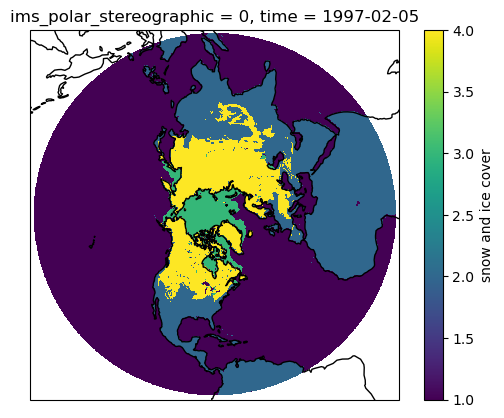

In [48]:
# fig = plt.figure(figsize=(7,7))
# ax = fig.add_subplots(
p = ds.surface_cover.squeeze().plot.imshow(subplot_kws=dict(projection=proj))
p.axes.coastlines()